Logs 
- [2023/05/13]   
  First version of this notebook


# Example 7.7 - Heteroscedasticity

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import scipy.stats as sc_stats
import tabulate

from sklearn.linear_model import LinearRegression

In [22]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 16,
  'grid.alpha': 0.25})

## Function declarations

### Read `ods` to `DataFrame`

In [5]:
def read_ods(filename, columns=None):
  if columns is None:
    df = pd.read_excel(filename, engine="odf", header=0)
  elif isinstance(columns, list):
    df = pd.read_excel(filename, engine="odf", header=0,
                       usecols=columns)
  else:
    key_arr = (k for k in columns.keys())
    df = pd.read_excel(filename, engine="odf", header=0,
                      usecols=key_arr)
    df = df.rename(columns=columns)
  return df

### Get multiple regression coefficients

In [6]:
def get_multiple_regress_coeff(df, n_vars=2, with_intercept=True):  

  regress_obj = LinearRegression(fit_intercept=with_intercept)

  if isinstance(df, pd.DataFrame):
    num_of_samples = len(df)
    X_arr = np.zeros((num_of_samples, n_vars))
    Y = df["Y"].to_numpy()

    for i in range(n_vars):
      key = f"X_{i+1}"
      X_arr[:, i] = df[key].to_numpy()

    regress = regress_obj.fit(X_arr, Y)
    df["hat_Y"] = regress.intercept_ + X_arr.dot(regress.coef_) 
  
  elif isinstance(df, np.ndarray):
    Y = df[:, 0]
    X_arr = df[:, 1:]

    
    regress = regress_obj.fit(X_arr, Y)
    Y_hat = regress.intercept_ + X_arr.dot(regress.coef_)
    df = np.column_stack([df, Y_hat])

  return regress, df


### Get Minitab output of Regression Analysis

In [7]:
def add_prediction_table(regress, df, significance_lvl=0.05):
  b0 = regress.intercept_
  b1 = regress.coef_[0]

  Y_tM1 = df["Y"].iloc[-1]        # Change this if the model is different

  n_data = len(df)
  hat_Y = b0 + b1*df_minitab["X_1"]

  meanX = df["X_1"].mean()
  sumOfSquareX_of_meanX = ((df["X_1"] - meanX)**2).sum()
  sumOfSquareY_of_hat_Y = ((df["Y"] - hat_Y)**2).sum()
  squareX = (Y_tM1 - meanX)**2

  std_yx = np.sqrt(sumOfSquareY_of_hat_Y/(n_data - 2))

  # -- for confidence interval (CI) and minitab S.E. of fit
  #    This measure the dispersion of the sample regression line
  #    about the population regression line
  std_err_fit = std_yx * np.sqrt(
    1./n_data + squareX/sumOfSquareX_of_meanX)

  std_forecast = std_yx * np.sqrt(
    1. + 1./n_data + squareX/sumOfSquareX_of_meanX)

  deg_of_freedom = n_data - 2
  l_bound = sc_stats.t.ppf(significance_lvl/2, deg_of_freedom)
  u_bound = sc_stats.t.ppf(1 - significance_lvl/2, deg_of_freedom)

  Y_t = b0 + b1*Y_tM1

  data = [
    [1, Y_t, std_err_fit, 
    f"({Y_t + l_bound * std_err_fit:.3f}, {Y_t + u_bound * std_err_fit:.3f})",
    f"({Y_t + l_bound * std_forecast:.3f}, {Y_t + u_bound * std_forecast:.3f})"]
  ]

  table_prediction = tabulate.tabulate(data, tablefmt='html', 
    headers=["New Obs", "Fit", "SE Fit", "95% CI", "95% PI"],
    floatfmt=[int, ".3f", ".3f", str, str])

  print(f"Predicted Values for New Observations")
  display(table_prediction)

In [8]:
def get_minitab_out(df, n_vars=2, new_column=None, withCorrMatrix=False, 
  withVIF=False, with_intercept=True, with_DW_stat=True, is_reg_diff=False,
  new_observ=0):

  """
  new_column (dict) : a dictionary mapping to rename df header
  is_reg_diff:
    True - if we perform regression difference of Y_t and X_t. 
    In this function, it only implements how to print the output not the
    calculation
  new_observ: int
    Number of forecasting point.
  """
  
  data_struct = np.zeros((len(df), 1+n_vars))
  data_struct[:, 0] = df['Y']
  for i in range(n_vars):
    key = f"X_{i+1}"
    data_struct[:, i+1] = df[key]

  # -- compute correlation matrix
  corr_matrix = np.corrcoef(data_struct, rowvar=False)
  corr_matrix = corr_matrix[1:, 0:-1]    # only show lower triangle part of correlation matrix

  # -- compute regression intercept and coefficients
  regress, _ = get_multiple_regress_coeff(df, n_vars=n_vars, with_intercept=with_intercept)
  b_arr = [regress.intercept_] + regress.coef_.tolist()
  is_positive_b_arr = [b_j > 0 for b_j in b_arr]
  #print(f"b_arr: {b_arr}")
  
  # -- compute standad error of the estimates
  num_of_samples = len(df)
  hat_Y =  regress.intercept_ + data_struct[:,1:].dot(regress.coef_)
  sumSq_Y_hat_Y = ((data_struct[:, 0] - hat_Y)**2).sum()

  if with_intercept:
    s_yxs = np.sqrt(sumSq_Y_hat_Y/(num_of_samples - n_vars - 1))
  else:
    s_yxs = np.sqrt(sumSq_Y_hat_Y/(num_of_samples - n_vars))

  # -- compute cofactor matrix 
  if with_intercept:
    X_arr = np.ones_like(data_struct)
    X_arr[:,1:] = data_struct[:,1:]
    cofactor_matrix = np.linalg.inv(X_arr.transpose().dot(X_arr))   # this matrix is closely related to covariance matrix
  else:
    X_arr = data_struct[:, 1:]
    cofactor_matrix = np.linalg.inv(X_arr.transpose().dot(X_arr))   # this matrix is closely related to covariance matrix
  

  # -- compute standard error of intercept_ and coef_
  # -- compute t-score of intecept_ and coef_
  # -- compute p-values of intercept_ and coef_
  SE_coef = np.zeros(1+n_vars)
  t_scores = np.zeros(1+n_vars)
  p_values = np.zeros(1+n_vars)
  
  if with_intercept:
    dof = num_of_samples - n_vars - 1;          # degrees of freedom
    for i in range(1+n_vars):
      SE_coef[i] = s_yxs*np.sqrt(cofactor_matrix[i, i])
      t_scores[i] = b_arr[i] / SE_coef[i]
      p_values[i] = sc_stats.t.sf(abs(t_scores[i]), dof) * 2   # .t.sf is a survival function (1 - cdf)
  else:
    dof = num_of_samples - n_vars;          # degrees of freedom
    for i in range(1, 1+n_vars):
      SE_coef[i] = s_yxs*np.sqrt(cofactor_matrix[i-1, i-1])
      t_scores[i] = b_arr[i] / SE_coef[i]
      p_values[i] = sc_stats.t.sf(abs(t_scores[i]), dof) * 2   # .t.sf is a survival function (1 - cdf)

  # -- compute VIF of coef_
  if withVIF:
    # if n_vars == 2, we calculate VIF from correlation matrix
    VIF_arr = np.zeros(n_vars)
    if n_vars == 2:
      VIF_arr[0] = 1/(1-corr_matrix[1, 1]**2)
      VIF_arr[1] = 1/(1-corr_matrix[1, 1]**2)
    else:
      for i in range(n_vars):
        # take a predictor column and put the other predictor after it
        predictor_data_struct = np.zeros((num_of_samples, n_vars))
        predictor_data_struct[:,0] = data_struct[:, i+1]   
        predictor_data_struct[:,1:] = np.delete(data_struct, i+1, axis=1)[:,1:]  
        #print(predictor_data_struct)
        predictor_SST, predictor_SSR, _ = get_sumSq(predictor_data_struct, n_vars=n_vars)
        predictor_R_sq = predictor_SSR/predictor_SST
        #print(predictor_R_sq)
        VIF_arr[i] = 1/(1 - predictor_R_sq)


  # -- compute ANOVA table
  meanY = data_struct[:, 0].mean()
  if with_intercept:
    SSR = ((hat_Y - meanY)**2).sum()
    SST = ((data_struct[:, 0] - meanY)**2).sum()
  else:
    SSR = (hat_Y**2).sum()
    SST = (data_struct[:, 0]**2).sum()

  SSE = ((data_struct[:, 0] - hat_Y)**2).sum()
  anova_sumSq = np.array([SSR, SSE, SST])

  if with_intercept:
    anova_dof = np.array([n_vars, num_of_samples - n_vars - 1, num_of_samples - 1], dtype=int)
  else:
    anova_dof = np.array([n_vars, num_of_samples - n_vars, num_of_samples], dtype=int)
  
  anova_meanSq = (anova_sumSq/anova_dof)[:2]
  anova_F_score = anova_meanSq[0] / anova_meanSq[1]
  anova_p_value = sc_stats.f.sf(anova_F_score, anova_dof[0], anova_dof[1])   # sf is a surfifal function (1 - cdf)

  # -- compute R_sq (coefficient of determination)
  R_sq = SSR/SST

  # -- compute adjusted R_sq
  adj_R_sq = 1 - (1 - R_sq)*(num_of_samples-1)/(num_of_samples-n_vars-1)
  
  # -- calculate Durbin-Watson statistics
  e_t = data_struct[:, 0] - hat_Y
  numerator = ((e_t[1:] - e_t[:-1])**2).sum()
  dw_stats = numerator / (e_t**2).sum()

  # -- create tabular form for correlation 
  if withCorrMatrix:
    data = []
    for i in range(n_vars):
      data_row = [new_column[i+1]] + \
        [f"{corr:.3f}" if j < i+1 else "" for j, corr in enumerate(corr_matrix[i,:])]
      #print(data_row)
      #print([type(data_row_i) for data_row_i in data_row])
      data.append(data_row)

    table_corr = tabulate.tabulate(data, tablefmt='html', 
      headers=[""] + new_column[:n_vars], 
      floatfmt=["None"] + [".3f"]*(n_vars))

    print(f"Correlations: {', '.join(new_column)}")
    display(table_corr)

  # -- create tabular form for predictor
  data = [["Constant", b_arr[0], SE_coef[0], t_scores[0], p_values[0]]]
  if withVIF:
    for i in range(1, n_vars+1):
      data_row = [new_column[i], b_arr[i], SE_coef[i], t_scores[i], p_values[i], VIF_arr[i-1]]
      data.append(data_row)
    table_predictor = tabulate.tabulate(data, tablefmt='html', 
      headers=["Predictor", "Coef", "SE Coef", "t-score", "p-value", "VIF"], 
      floatfmt=[None, ".4f", ".4f", ".2f", ".4f", ".3f"])
  else:
    for i in range(1, n_vars+1):
      data_row = [new_column[i], b_arr[i], SE_coef[i], t_scores[i], p_values[i]]
      data.append(data_row)
    table_predictor = tabulate.tabulate(data, tablefmt='html', 
      headers=["Predictor", "Coef", "SE Coef", "t-score", "p-value"], 
      floatfmt=[None, ".4f", ".4f", ".2f", ".4f"])


  print(f"Regression Analysis: {new_column[0]} versus {', '.join(new_column[1:])}")
  print("The regression equation is")
  str_b_predictor = "" 
  for i in range(n_vars):
    sign = "+" if is_positive_b_arr[i+1] else "-"
    str_b_predictor += f" {sign} {abs(b_arr[i+1]):.3f} {new_column[i+1]}"
  if with_intercept:
    print(f"{new_column[0]} = {b_arr[0]:.3f}{str_b_predictor}")
  else:
    if str_b_predictor[1] == "+":
      str_b_predictor = str_b_predictor[3:]
    print(f"{new_column[0]} = {str_b_predictor}")
  display(table_predictor)
  if is_reg_diff:
    print(f"s_yxs = {s_yxs:.4f}")
  else:
    print(f"s_yxs = {s_yxs:.4f}   R_sq = {R_sq*100:.1f}%   R-sq(adj) = {adj_R_sq*100:.1f}%")

  # -- create ANOVA table (with F-score and its p-value)
  data = [
    ["Regression",     anova_dof[0], anova_sumSq[0], f"{anova_meanSq[0]:.4f}", f"{anova_F_score:.3f}", f"{anova_p_value:.4f}"],
    ["Residual error", anova_dof[1], anova_sumSq[1], f"{anova_meanSq[1]:.4f}", "", ""],
    ["Total",          anova_dof[2], anova_sumSq[2], "", "", ""]] 
  table_anova = tabulate.tabulate(data, tablefmt='html', 
    headers=["Source", "d.o.f", "sumSq", "meanSq", "F-score", "p-value"], 
    floatfmt=[None, ".0f", ".4f", "s", "s", "s"])

  print(f"Analyis of Variance")
  display(table_anova)

  if new_observ > 0:
    add_prediction_table(regress, df)

  # -- print Durbin-Watson statistics
  if with_DW_stat:
    print(f"Durbin-Watson Statistics = {dw_stats:.2f}")

  return {"regress": regress, "param_stderr": SE_coef, 
    "param_t_stat": t_scores, "param_p_vals": p_values,
    "corr_matrix": corr_matrix, "R_sq": R_sq, "dw_stats": dw_stats}


## Load the data

### Sales and income data

In [9]:
filename = "07-table-01-reynolds-metals-sales.ods"

df = read_ods(filename)

df

,Year,Sales Y_t,Income X_t
0,1986,295,273.4
1,1987,400,291.3
2,1988,390,306.9
3,1989,425,317.1
4,1990,547,336.1
5,1991,555,349.4
6,1992,620,362.9
7,1993,720,383.9
8,1994,880,402.8
9,1995,1050,437.0


## Simple linear regression

### Regression Analysis

In [12]:
df_minitab = df[["Sales Y_t", "Income X_t"]]
from_column_names = df_minitab.columns.to_list()
print(f"header: {from_column_names}")
to_column_names = ["Y"] + [f"X_{i+1}" for i in range(len(from_column_names) - 1)]


df_minitab = df_minitab.rename(columns=
  {k: v for k, v in zip(from_column_names, to_column_names)})

df_minitab

header: ['Sales Y_t', 'Income X_t']


,Y,X_1
0,295,273.4
1,400,291.3
2,390,306.9
3,425,317.1
4,547,336.1
5,555,349.4
6,620,362.9
7,720,383.9
8,880,402.8
9,1050,437.0


In [68]:
column_name = ["ln(Sales)", "ln(Income)"]
out_dict = get_minitab_out(df_minitab, n_vars=len(column_name)-1, 
  new_column=column_name, withVIF=False, withCorrMatrix=False)

Regression Analysis: ln(Sales) versus ln(Income)
The regression equation is
ln(Sales) = -792.002 + 4.255 ln(Income)


Predictor,Coef,SE Coef,t-score,p-value
Constant,-792.0024,187.1275,-4.23,0.0005
ln(Income),4.2552,0.3163,13.45,0.0000


s_yxs = 341.1008   R_sq = 90.5%   R-sq(adj) = 90.0%
Analyis of Variance


Source,d.o.f,sumSq,meanSq,F-score,p-value
Regression,1,21061160.2150,21061160.2150,181.016,0.0000
Residual error,19,2210645.5946,116349.7681,,
Total,20,23271805.8095,,,


Durbin-Watson Statistics = 0.87


### Fitted line plot

In [69]:
df_fit = df_minitab.copy()
df_fit["t"] = df["Year"]

display(df_fit)
out_dict

,Y,X_1,hat_Y,t
0,295,273.4,371.360185,1986
1,400,291.3,447.527672,1987
2,390,306.9,513.908275,1988
3,425,317.1,557.310977,1989
4,547,336.1,638.159147,1990
5,555,349.4,694.752866,1991
6,620,362.9,752.197618,1992
7,720,383.9,841.556122,1993
8,880,402.8,921.978776,1994
9,1050,437.0,1067.505482,1995


{'regress': LinearRegression(),
 'param_stderr': array([187.12754831,   0.31627015]),
 'param_t_stat': array([-4.23242029, 13.45421566]),
 'param_p_vals': array([4.50723701e-04, 3.66795803e-11]),
 'corr_matrix': array([[0.95131885]]),
 'R_sq': 0.9050075609661654,
 'dw_stats': 0.8712532014949105}

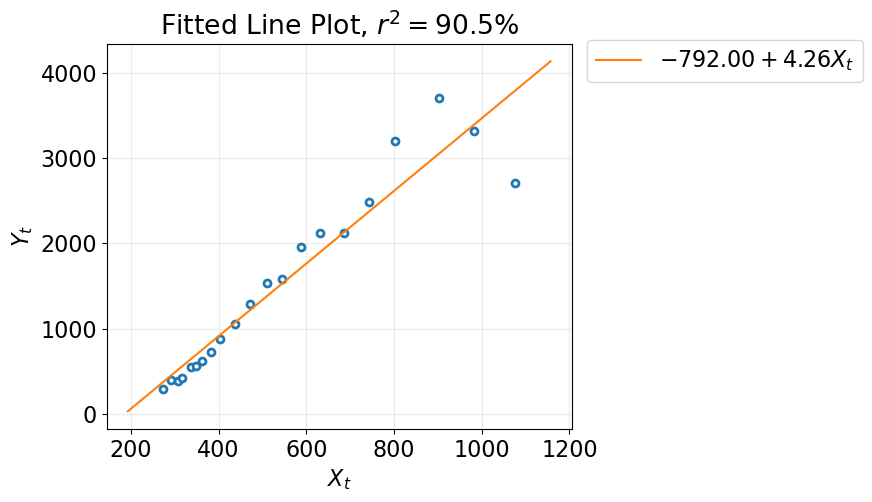

In [70]:
fig, ax = plt.subplots(figsize=(6, 5))

ax.plot(df_fit["X_1"], df_fit["Y"], 
  marker='o', markersize=5, markerfacecolor='white',
  linestyle='None', markeredgewidth=2) 

regress = out_dict["regress"]
b0 = regress.intercept_
b1 = regress.coef_[0]

data_t_min = df_fit["X_1"].min()
data_t_max = df_fit["X_1"].max()
t_offset = 0.1*(data_t_max - data_t_min)
t_regress = np.linspace(data_t_min - t_offset, data_t_max + t_offset)
regress_label = r"${:.2f} + {:.2f}X_t$".format(b0, b1) \
  if b1 > 0 else r"${:.2f}{:.2f}X_t$".format(b0, b1)

ax.plot(t_regress, b0 + b1*t_regress, 
  linestyle='-',
  label=regress_label) 

ax.set_xlabel(r"$X_t$")
ax.set_ylabel(r"$Y_t$")

rSq = out_dict["R_sq"]
ax.set_title(r"Fitted Line Plot, $r^2={:.1f}$%".format(rSq*100))

ax.legend(loc="upper left", bbox_to_anchor=[1.01, 1.04])
ax.grid("on")
plt.show(fig)

### Residuals-Linear Fit Plot

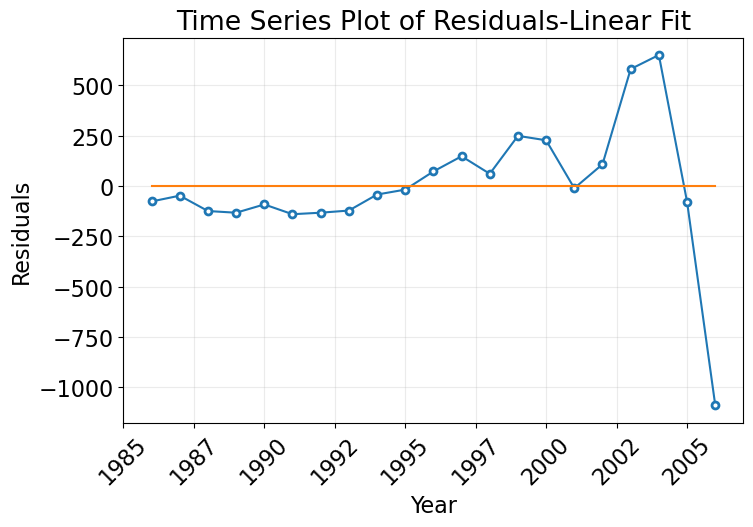

In [71]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(df_fit["t"], df_fit["Y"] - df_fit["hat_Y"], 
  marker='o', markersize=5, markerfacecolor='white',
  linestyle='-', markeredgewidth=2) 

ax.plot([df_fit["t"].iloc[0], df_fit["t"].iloc[-1]], [0, 0])

ax.grid("on")

ax.set_ylabel("Residuals")
ax.set_xlabel("Year")

ax.set_title("Time Series Plot of Residuals-Linear Fit")

ax.tick_params(axis="x", labelrotation=45)
ax.ticklabel_format(axis="x", style="plain")
ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%d"))
plt.show(fig)

## Log Linear Model

$$
\begin{align*}
  Y_t &= \gamma X_t^{\beta_1} + \epsilon_t \\
  \ln{Y_t} &= \beta_0 + \beta_1 \ln{X_t} + \epsilon_t
\end{align*}
$$

where $\beta_0 = \ln{\gamma}$ and $\beta_1$ is the income elasticity of sales

### Regression Analysis

In [72]:
df_minitab_log = df_minitab.copy()

df_minitab_log["ln X_t"] = np.log(df_minitab_log["X_1"])
df_minitab_log["ln Y_t"] = np.log(df_minitab_log["Y"])

df_minitab_log = df_minitab_log[["ln Y_t", "ln X_t"]]
from_column_names = df_minitab_log.columns.to_list()
print(f"header: {from_column_names}")
to_column_names = ["Y"] + [f"X_{i+1}" for i in range(len(from_column_names) - 1)]


df_minitab_log = df_minitab_log.rename(columns=
  {k: v for k, v in zip(from_column_names, to_column_names)})

df_minitab_log

header: ['ln Y_t', 'ln X_t']


,Y,X_1
0,5.686975,5.610936
1,5.991465,5.674354
2,5.966147,5.726522
3,6.052089,5.759217
4,6.304449,5.817409
5,6.318968,5.856217
6,6.429719,5.894127
7,6.579251,5.950382
8,6.779922,5.998440
9,6.956545,6.079933


In [89]:
column_name = ["ln(Sales)", "ln(Income)"]
out_dict_log = get_minitab_out(df_minitab_log, n_vars=len(column_name)-1, 
  new_column=column_name, withVIF=False, withCorrMatrix=False)

Regression Analysis: ln(Sales) versus ln(Income)
The regression equation is
ln(Sales) = -4.399 + 1.843 ln(Income)


Predictor,Coef,SE Coef,t-score,p-value
Constant,-4.3985,0.6629,-6.63,0.0000
ln(Income),1.8430,0.1065,17.30,0.0000


s_yxs = 0.2019   R_sq = 94.0%   R-sq(adj) = 93.7%
Analyis of Variance


Source,d.o.f,sumSq,meanSq,F-score,p-value
Regression,1,12.1956,12.1956,299.268,0.0000
Residual error,19,0.7743,0.0408,,
Total,20,12.9699,,,


Durbin-Watson Statistics = 0.47


### Fitted line plot

In [90]:
df_fit_log = df_minitab_log.copy()
df_fit_log["t"] = df["Year"]
display(df_fit_log)

out_dict_log

,Y,X_1,hat_Y,t
0,5.686975,5.610936,5.942284,1986
1,5.991465,5.674354,6.059161,1987
2,5.966147,5.726522,6.155305,1988
3,6.052089,5.759217,6.215562,1989
4,6.304449,5.817409,6.322807,1990
5,6.318968,5.856217,6.394330,1991
6,6.429719,5.894127,6.464197,1992
7,6.579251,5.950382,6.567873,1993
8,6.779922,5.998440,6.656442,1994
9,6.956545,6.079933,6.806632,1995


{'regress': LinearRegression(),
 'param_stderr': array([0.66293632, 0.10653395]),
 'param_t_stat': array([-6.6348789 , 17.29936706]),
 'param_p_vals': array([2.39455996e-06, 4.37057193e-13]),
 'corr_matrix': array([[0.96969165]]),
 'R_sq': 0.9403019028481407,
 'dw_stats': 0.46991760168880403}

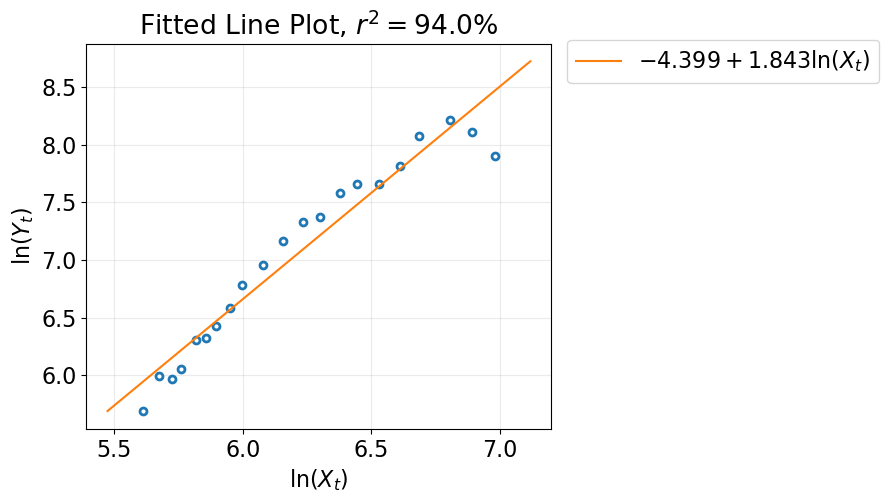

In [91]:
fig, ax = plt.subplots(figsize=(6, 5))

ax.plot(df_fit_log["X_1"], df_fit_log["Y"], 
  marker='o', markersize=5, markerfacecolor='white',
  linestyle='None', markeredgewidth=2) 

regress = out_dict_log["regress"]
b0 = regress.intercept_
b1 = regress.coef_[0]

data_t_min = df_fit_log["X_1"].min()
data_t_max = df_fit_log["X_1"].max()
t_offset = 0.1*(data_t_max - data_t_min)
t_regress = np.linspace(data_t_min - t_offset, data_t_max + t_offset)
regress_label = r"${:.3f} + {:.3f}\ln(X_t)$".format(b0, b1) \
  if b1 > 0 else r"${:.3f}{:.3f}\ln(X_t)$".format(b0, b1)

ax.plot(t_regress, b0 + b1*t_regress, 
  linestyle='-',
  label=regress_label) 

ax.set_xlabel(r"$\ln(X_t)$")
ax.set_ylabel(r"$\ln(Y_t)$")

rSq = out_dict_log["R_sq"]
ax.set_title(r"Fitted Line Plot, $r^2={:.1f}$%".format(rSq*100))

ax.legend(loc="upper left", bbox_to_anchor=[1.01, 1.04])
ax.grid("on")
plt.show(fig)

### Residual-Log Linear Plot

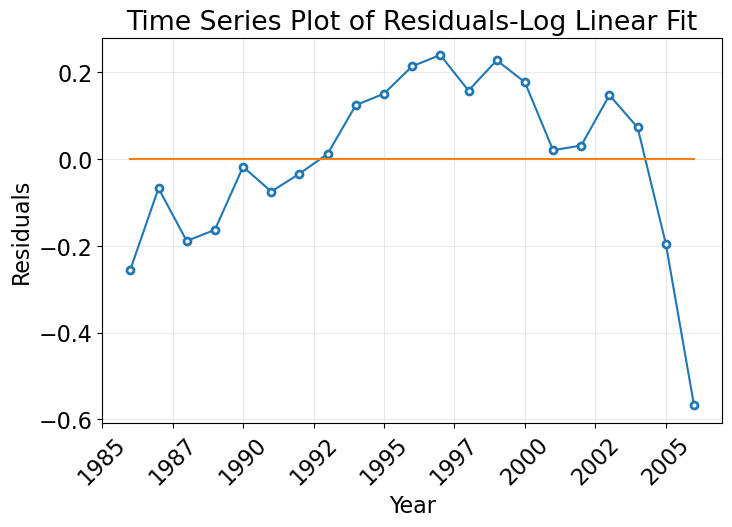

In [92]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(df_fit_log["t"], df_fit_log["Y"] - df_fit_log["hat_Y"], 
  marker='o', markersize=5, markerfacecolor='white',
  linestyle='-', markeredgewidth=2) 

ax.plot([df_fit_log["t"].iloc[0], df_fit_log["t"].iloc[-1]], [0, 0])

ax.grid("on")

ax.set_ylabel("Residuals")
ax.set_xlabel("Year")

ax.set_title("Time Series Plot of Residuals-Log Linear Fit")

ax.tick_params(axis="x", labelrotation=45)
ax.ticklabel_format(axis="x", style="plain")
ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%d"))
plt.show(fig)

## Log Quadratic Model

$$
\begin{align*}
  \ln{Y_t} &= \beta_0 + \beta_1 \ln{X_t} + \beta_2 \left(\ln{X_t}\right)^2 + \epsilon_t
\end{align*}
$$


### Regression Analysis

In [93]:
df_minitab_log_quad = df_minitab.copy()

df_minitab_log_quad["ln X_t"] = np.log(df_minitab_log["X_1"])
df_minitab_log_quad["ln Y_t"] = np.log(df_minitab_log["Y"])
df_minitab_log_quad["(ln X_t)^2"] = df_minitab_log_quad["ln X_t"]**2

df_minitab_log_quad = df_minitab_log_quad[["ln Y_t", "ln X_t", "(ln X_t)^2"]]
from_column_names = df_minitab_log_quad.columns.to_list()
print(f"header: {from_column_names}")
to_column_names = ["Y"] + [f"X_{i+1}" for i in range(len(from_column_names) - 1)]

df_minitab_log_quad = df_minitab_log_quad.rename(columns=
  {k: v for k, v in zip(from_column_names, to_column_names)})

df_minitab_log_quad

header: ['ln Y_t', 'ln X_t', '(ln X_t)^2']


,Y,X_1,X_2
0,1.738179,1.724718,2.974651
1,1.790336,1.735957,3.013546
2,1.786101,1.745108,3.045403
3,1.800404,1.750802,3.065306
4,1.841256,1.760855,3.100610
5,1.843556,1.767504,3.124070
6,1.860931,1.773956,3.146922
7,1.883921,1.783455,3.180713
8,1.913966,1.791499,3.209470
9,1.939683,1.804994,3.258002


In [94]:
column_name = ["ln(Sales)", "ln(Income)", "(ln(Income))^2"]
out_dict_log_quad = get_minitab_out(df_minitab_log_quad, n_vars=len(column_name)-1, 
  new_column=column_name, withVIF=False, withCorrMatrix=False)

Regression Analysis: ln(Sales) versus ln(Income), (ln(Income))^2
The regression equation is
ln(Sales) = -23.320 + 25.967 ln(Income) - 6.633 (ln(Income))^2


Predictor,Coef,SE Coef,t-score,p-value
Constant,-23.3205,2.3893,-9.76,0.0000
ln(Income),25.9674,2.6109,9.95,0.0000
(ln(Income))^2,-6.6333,0.7125,-9.31,0.0000


s_yxs = 0.0125   R_sq = 99.0%   R-sq(adj) = 98.8%
Analyis of Variance


Source,d.o.f,sumSq,meanSq,F-score,p-value
Regression,2,0.2669,0.1334,859.687,0.0000
Residual error,18,0.0028,0.0002,,
Total,20,0.2697,,,


Durbin-Watson Statistics = 1.50


### Fitted line plot

In [95]:
df_fit_log_quad = df_minitab_log_quad.copy()
df_fit_log_quad["t"] = df["Year"]
display(df_fit_log_quad)

out_dict_log_quad

,Y,X_1,X_2,hat_Y,t
0,1.738179,1.724718,2.974651,1.734184,1986
1,1.790336,1.735957,3.013546,1.768032,1987
2,1.786101,1.745108,3.045403,1.794356,1988
3,1.800404,1.750802,3.065306,1.810171,1989
4,1.841256,1.760855,3.100610,1.837049,1990
5,1.843556,1.767504,3.124070,1.854088,1991
6,1.860931,1.773956,3.146922,1.870063,1992
7,1.883921,1.783455,3.180713,1.892575,1993
8,1.913966,1.791499,3.209470,1.910703,1994
9,1.939683,1.804994,3.258002,1.939186,1995


{'regress': LinearRegression(),
 'param_stderr': array([2.38932636, 2.61086611, 0.71246943]),
 'param_t_stat': array([-9.7602675 ,  9.94590292, -9.31032642]),
 'param_p_vals': array([1.29569668e-08, 9.70785754e-09, 2.65115589e-08]),
 'corr_matrix': array([[0.96940544, 1.        ],
        [0.96576523, 0.99987583]]),
 'R_sq': 0.9896395395066365,
 'dw_stats': 1.498830782347506}

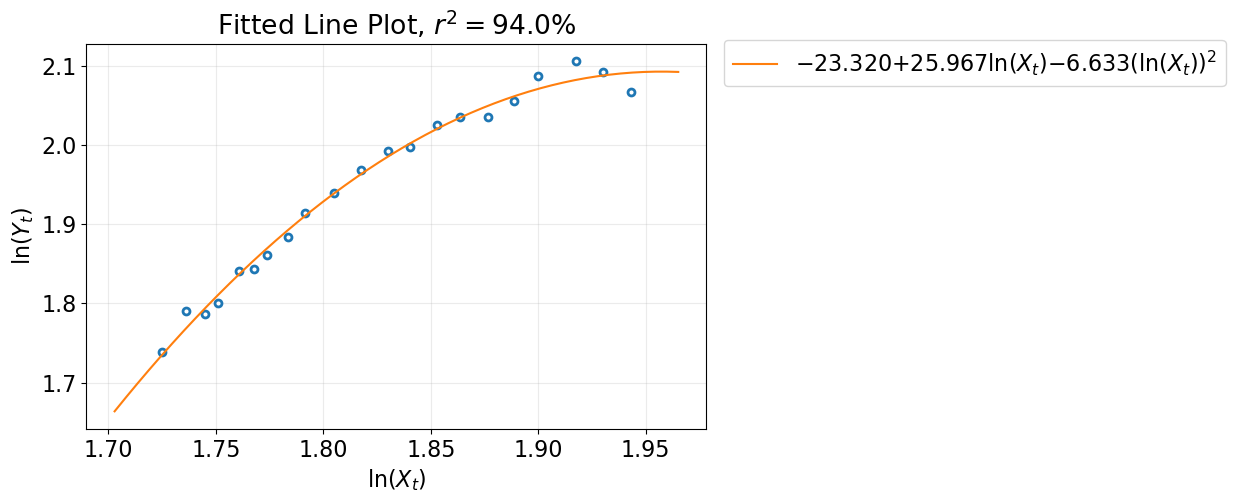

In [102]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(df_fit_log_quad["X_1"], df_fit_log_quad["Y"], 
  marker='o', markersize=5, markerfacecolor='white',
  linestyle='None', markeredgewidth=2) 

regress = out_dict_log_quad["regress"]
b0 = regress.intercept_
b1 = regress.coef_[0]
b2 = regress.coef_[1]

data_t_min = df_fit_log_quad["X_1"].min()
data_t_max = df_fit_log_quad["X_1"].max()
t_offset = 0.1*(data_t_max - data_t_min)
t_regress = np.linspace(data_t_min - t_offset, data_t_max + t_offset)

regress_label_b1 = r"$ + {:.3f}\ln(X_t)$".format(b1) \
  if b1 > 0 else r"${:.3f}\ln(X_t)$".format(b1)
regress_label_b2 = r"$ + {:.3f}(\ln(X_t))^2$".format(b2) \
  if b2 > 0 else r"${:.3f}(\ln(X_t))^2$".format(b2)
regress_label = r"${:.3f}${:s}{:s}" .format(
  b0, regress_label_b1, regress_label_b2)

ax.plot(t_regress, b0 + b1*t_regress + b2*t_regress**2, 
  linestyle='-',
  label=regress_label) 

ax.set_xlabel(r"$\ln(X_t)$")
ax.set_ylabel(r"$\ln(Y_t)$")

rSq = out_dict_log["R_sq"]
ax.set_title(r"Fitted Line Plot, $r^2={:.1f}$%".format(rSq*100))

ax.legend(loc="upper left", bbox_to_anchor=[1.01, 1.04])
ax.grid("on")
plt.show(fig)

### Residual-Log Quadratic Plot

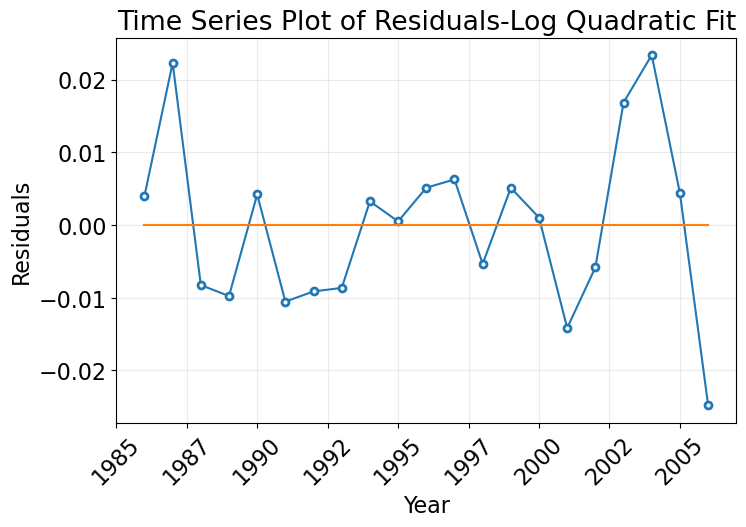

In [103]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(df_fit_log_quad["t"], df_fit_log_quad["Y"] - df_fit_log_quad["hat_Y"], 
  marker='o', markersize=5, markerfacecolor='white',
  linestyle='-', markeredgewidth=2) 

ax.plot([df_fit_log_quad["t"].iloc[0], df_fit_log_quad["t"].iloc[-1]], [0, 0])

ax.grid("on")

ax.set_ylabel("Residuals")
ax.set_xlabel("Year")

ax.set_title("Time Series Plot of Residuals-Log Quadratic Fit")

ax.tick_params(axis="x", labelrotation=45)
ax.ticklabel_format(axis="x", style="plain")
ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%d"))
plt.show(fig)